In [0]:
%matplotlib inline
import numpy as np
import matplotlib
import sys 

sys.path.insert(0,'..')
from utils import plot_stroke

In [0]:
strokes = np.load('data/strokes.npy')      # loads the input stroke data, size : (6000,<seq_length>,3)
with open('data/sentences.txt') as f:
    texts = f.readlines()                  # loads the corresponding text label, size : (6000,<sentence_length>)

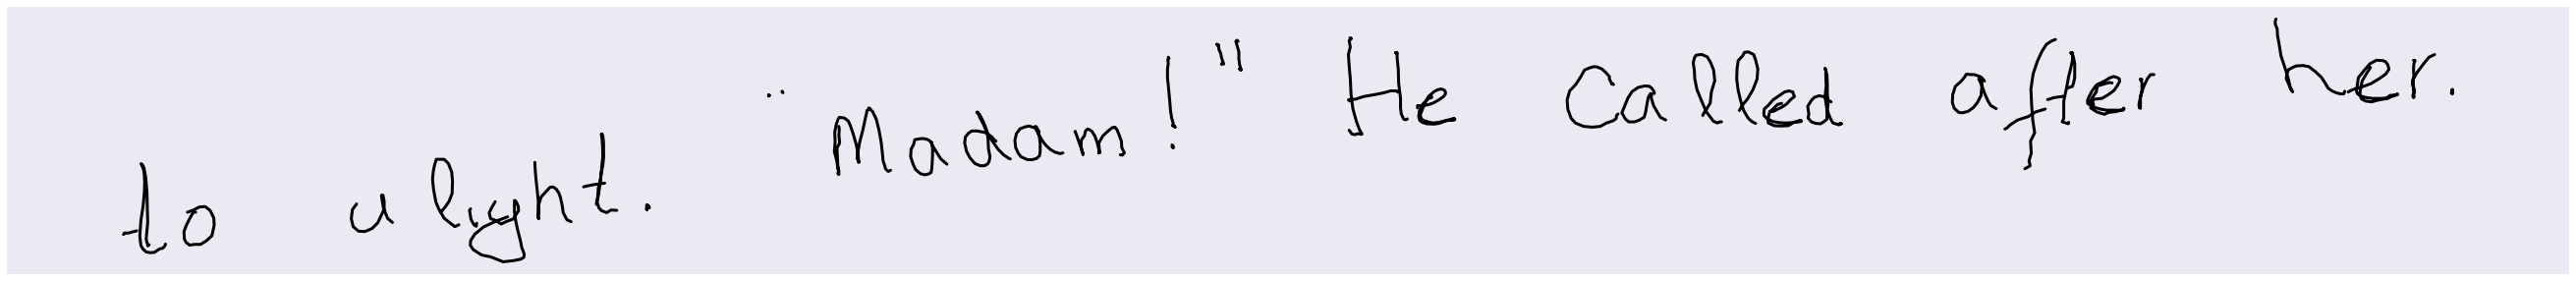

TEXT: to alight. "Madam!" He called after her.



In [4]:
idx = 13
stroke = strokes[idx]
text = texts[idx]
plot_stroke(stroke)
print 'TEXT:', text

In [5]:
print strokes.shape
print strokes[0].shape
print len(texts)

(6000,)
(739, 3)
6000


In [6]:
max = 0
min = 10000 # randomly chosen upperbound
index_max = 0
index_min = 0
for i,stroke in enumerate(strokes):
    if max < len(stroke):             # maximum stroke length in 1191
        max = len(stroke)
        index_max = i
    if min > len(stroke):             # minimum stroke length is 301
        min = len(stroke)
        index_min = i
print max,index_max
print min,index_min

1191 4440
301 893


In [7]:
max = 0
index = 0
for i,text in enumerate(texts):
    if max < len(text):
        max = len(text)                     # maximum text length is 65
        index = i
print max,index

65 2448


In [0]:
seq_len = []
strokes_array = np.ndarray(dtype = int, shape = (len(strokes),1200,3))
for i,stroke in enumerate(strokes):
    seq_len.append(len(stroke))                           # a list of all the stroke sequence lengths
    for _ in range(1200-len(stroke)):                     # making all the stroke inputs of uniform length 1200
        stroke = np.vstack((stroke, [[1,0,0]]))             # As the LSTM model is unrolled for 1200 timesteps
    strokes_array[i] = stroke

In [9]:
strokes_array.shape

(6000, 1200, 3)

In [0]:
num = np.zeros(1000)                                # 1000 is chosen arbitrarily just as an upperbound to compute the
for text in texts:                                  # dictionaries for character encodings and decodings
    for ch in text:
        if num[ord(ch)] == 0 :
        num[ord(ch)] = 1
char_decoding = []
for ch_num,x in enumerate(num) :
    if x == 1 :
        char_decoding.append(ch_num)
char_encoding = {}
for i,ch_num in enumerate(char_decoding) :
    char_encoding[ch_num] = i

In [11]:
len(char_encoding)

78

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

text_num_array = []
input_onehot_encoder = OneHotEncoder(n_values=len(char_encoding),sparse = False)
for text in texts :
    temp = []
    for ch in text :                                              
        temp.append(char_encoding[ord(ch)])         
    temp = np.asarray(temp)
    temp = temp.reshape(len(temp), 1)
    input_onehot_encoded = input_onehot_encoder.fit_transform(temp)       # input_onehot_encoded shape [sentence_length, 78]                                                                 
    zer = np.zeros((70-len(input_onehot_encoded),len(char_encoding)))     # zer shape = [70,78] {appending zero(78) columns
                                                                        # won't affect the 'w' calculations}
    text_num_array.append(np.concatenate((input_onehot_encoded,zer),0))   # a list of text labels of length 6000

In [0]:
from sklearn.model_selection import train_test_split
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, train_seq_len, test_seq_len, Y_train, Y_val = train_test_split(strokes_array, seq_len, text_num_array, test_size = 0.1, random_state=random_seed)

In [0]:
timesteps = 1200                     # LSTM network is unrolled for 1200 timesteps
hidden_dim = 30 #300
epochs = 10
batch_size = 10
#input_dims = len(char_encoding)
num_gaussians_mixturemodel = 20                # number of gaussians in the mixture model to predict outputs
output_dim = 6*num_gaussians_mixturemodel + 1  # =121
bias = 0

In [0]:
import tensorflow as tf
g1 = tf.Graph()
with g1.as_default():
    with tf.variable_scope("Handwriting_Prediction") :
        #  Sequences we will provide at runtime
        seq_len = tf.placeholder(tf.int32, [batch_size])
        stroke_input = tf.placeholder(tf.float32, [batch_size, timesteps, 3])  
        initializer = tf.contrib.layers.xavier_initializer()

        stroke_list = tf.transpose(stroke_input, perm = [1,0,2])
        inputs = tf.unstack(value = stroke_list, axis = 0)
        with tf.variable_scope("Recurrent_Connections") :
            cell1 = tf.contrib.rnn.LSTMCell(hidden_dim, 3, initializer=initializer)
            initial_state1 = cell1.zero_state(batch_size, tf.float32)
            outputs1, states1 = tf.contrib.rnn.static_rnn(cell1, inputs, initial_state=initial_state1, scope="RNN1", sequence_length=seq_len)

            input_layer2 = tf.unstack(tf.concat([outputs1, inputs], 2), axis = 0)        # uses skip connections to easen gradient flow -> inputs2 = outputs1+inputs1

            cell2 = tf.contrib.rnn.LSTMCell(hidden_dim, hidden_dim + 3, initializer=initializer)
            initial_state2 = cell2.zero_state(batch_size, tf.float32)
            outputs2, states2 = tf.contrib.rnn.static_rnn(cell2, input_layer2, initial_state=initial_state2, scope="RNN2", sequence_length=seq_len)

            input_layer3 = tf.unstack(tf.concat([outputs2, inputs], 2), axis = 0)       # inputs3 = outputs3+inputs1

            cell3 = tf.contrib.rnn.LSTMCell(hidden_dim, hidden_dim+3, initializer=initializer)
            initial_state3 = cell3.zero_state(batch_size, tf.float32)
            outputs3, states3 = tf.contrib.rnn.static_rnn(cell3, input_layer3, initial_state=initial_state3,scope="RNN3", sequence_length=seq_len)

        with tf.variable_scope("Dense_Connections") :
            input_layer4 = tf.reshape(tf.transpose(tf.concat([outputs3, outputs2, outputs1], 2), perm = [1,0,2]), [batch_size*timesteps, 3*hidden_dim])
            # inputs to the dense layer are the hidden units of all the three RNNs
            output = tf.layers.dense(input_layer4, output_dim)
            output_list = tf.reshape(output, [batch_size, timesteps, output_dim])

            x3 = 1 / (1 + tf.exp(output_list[:, :, 0]))
            weights, x1_mean, x2_mean, x1_var, x2_var, correlation = tf.split(axis = 2, num_or_size_splits = 6, value = output_list[:, :, 1:])      
            weight_norm = tf.exp(weights * (1 + bias)) / tf.tile(tf.reduce_sum(tf.exp(weights * (1 + bias)), 2, keep_dims = True), [1,1,num_gaussians_mixturemodel])
            x1_var_norm = tf.exp(x1_var - bias)
            x2_var_norm = tf.exp(x2_var - bias)
            correlation_norm = tf.tanh(correlation)

            x3_target, x2_target, x1_target = tf.unstack(tf.concat([stroke_input[:, 1:, :],[[[1,0,0]]]*batch_size], axis = 1), axis = 2)
            x1_target_M = tf.reshape(tf.tile(x1_target, [1,num_gaussians_mixturemodel]), [batch_size, timesteps, num_gaussians_mixturemodel])
            x2_target_M = tf.reshape(tf.tile(x2_target, [1,num_gaussians_mixturemodel]), [batch_size, timesteps, num_gaussians_mixturemodel])

            z = tf.square((x1_target_M-x1_mean)/x1_var_norm) + tf.square((x2_target_M-x2_mean)/x2_var_norm) - 2*correlation_norm*(x1_target_M-x1_mean)*(x2_target_M-x2_mean)/(x1_var_norm*x2_var_norm)
            denominator = 2*np.pi*x1_var_norm*x2_var_norm*tf.sqrt(1 - tf.square(correlation_norm))

            Prob = tf.exp(-z/(2*(1-tf.square(correlation_norm)))) / denominator
            Prob_norm = Prob*weight_norm
            prediction_loss = -1*tf.reduce_mean(tf.reduce_sum(tf.log(tf.reduce_sum(Prob_norm, axis = 2)), axis=1))/100
            cross_entropy_loss = -1*tf.reduce_mean(tf.reduce_sum(x3_target*tf.log(x3)+(1-x3_target)*tf.log(1-x3), axis = 1))
            loss = prediction_loss + cross_entropy_loss

        #train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
    
        optimizer = tf.train.AdamOptimizer(1e-4)
        gradients_variables = optimizer.compute_gradients(loss)
        recurrent_gvs = [(tf.clip_by_value(grad, -10, 10), var) for grad, var in gradients_variables if var.name.startswith("Handwriting_Prediction/Recurrent_Connections")]
        dense_gvs = [(tf.clip_by_value(grad, -100, 100), var) for grad, var in gradients_variables if var.name.startswith("Handwriting_Prediction/Dense_Connections")]
        # gradient clipping to avoid exploding gradient problem
        recurrent_vars = [var for grad, var in gradients_variables if var.name.startswith("Handwriting_Prediction/Recurrent_Connections")]
        dense_vars = [var for grad, var in gradients_variables if var.name.startswith("Handwriting_Prediction/Dense_Connections")]

        other_gvs = [(grad, var) for grad, var in gradients_variables if var not in (recurrent_vars+dense_vars)]
        train_step = optimizer.apply_gradients(recurrent_gvs+dense_gvs+other_gvs)
        #gradients, _ = tf.clip_by_global_norm(gradients, 100.0) 
        # use of tf.clip_by_global_norm allows better convergence as it doesn't introduce bias/avoids spurious gradient directions
        
    # Create initialize op, this needs to be run by the session!
    iop = tf.initialize_all_variables()
    saver = tf.train.Saver()
    print "done"
    #tf.get_variable_scope().reuse_variables()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
session = tf.Session(graph = g1)

# Actually initialize, if you don't do this you get errors about uninitialized
session.run(iop)

#save_path = saver.save(session, "Checkpoints/Unconditional_model.ckpt")
#print("Model saved in path: %s" % save_path)

num_batches = len(X_train) // batch_size                  # X_train.shape[1]//batch_size - 1
for i in range(epochs) :
  
    for batch in range(num_batches):
        batch_input = X_train[batch*batch_size : (batch+1)*batch_size,:timesteps,:]
    #    batch_input = list(batch_input)
        feed = {stroke_input: batch_input.astype('float32'), seq_len : train_seq_len[batch*batch_size : (batch+1)*batch_size]}
        #print(Y_batch.shape)
        _,pl,cl,l = session.run([train_step, prediction_loss, cross_entropy_loss, loss], feed_dict=feed)

        if batch%10==0 :
            print("    prediction_loss :"+str(pl)+"    crossentropy_loss :"+str(cl)+"    total_loss :"+str(l))
    print("-------------------------epoch : "+str(i))
  
    save_path = saver.save(session, "Checkpoints/Unconditional_model.ckpt")
    print("Model saved in path: %s" % save_path)

    prediction_loss :6.512987    crossentropy_loss :206.43167    total_loss :212.94466
    prediction_loss :6.538285    crossentropy_loss :202.60999    total_loss :209.14827
    prediction_loss :6.20922    crossentropy_loss :199.54471    total_loss :205.75392
    prediction_loss :6.3167906    crossentropy_loss :195.9941    total_loss :202.31088
    prediction_loss :6.2510486    crossentropy_loss :192.27965    total_loss :198.5307
    prediction_loss :6.4461203    crossentropy_loss :183.24945    total_loss :189.69557
    prediction_loss :6.3099823    crossentropy_loss :178.50827    total_loss :184.81825
    prediction_loss :6.174378    crossentropy_loss :166.71426    total_loss :172.88864
    prediction_loss :5.8703265    crossentropy_loss :157.49265    total_loss :163.36298
    prediction_loss :5.4627213    crossentropy_loss :139.26773    total_loss :144.73045
    prediction_loss :5.3407555    crossentropy_loss :117.88192    total_loss :123.22267
    prediction_loss :4.566936    crosse

KeyboardInterrupt: ignored

In [ ]:
from sklearn.mixture import GaussianMixture
session = tf.Session(graph = g1)

# Actually initialize, if you don't do this you get errors about uninitialized
session.run(iop)

#save_path = saver.restore(session, "Checkpoints/Unconditional_model.ckpt")

initial = np.zeros([3,], np.float32)
initial[0] = 1
strokes_test = np.zeros([batch_size, timesteps, 3], dtype=np.float32)
stroke_output = np.zeros([timesteps, 3], dtype=np.float32)
state1, state2, state3 = session.run([initial_state1,initial_state2,initial_state3])
stroke_output[0, :] = initial[:]
for i in range(timesteps-1):
    strokes_test[0, 0, :] = initial[:]
    feed_dict = {stroke_input: strokes_test, seq_len: [1]*10, initial_state1: state1, initial_state2: state2, initial_state3: state3}  
    stroke_prob, prob_weights, mu1, mu2, var1, var2, corel_coeff, state1, state2, state3 = session.run([x3, weight_norm, x1_mean, x2_mean,x1_var_norm, x2_var_norm, correlation_norm, states1, states2, states3], feed_dict=feed_dict)

    stroke_prob = stroke_prob[0,0]
    prob_weights = prob_weights[0,0,:]
    means_matrix = np.zeros([num_gaussians_mixturemodel, 2], np.float32)
    means_matrix[:,0] = mu1[0,0,:]
    means_matrix[:,1] = mu2[0,0,:]
    cov_matrix = np.zeros([num_gaussians_mixturemodel, 2, 2], np.float32)
    for it in range(num_gaussians_mixturemodel):
        cov_matrix[it,:,:] = [[var1[0,0,it]*var1[0,0,it], corel_coeff[0,0,it]*var1[0,0,it]*var2[0,0,it]],[corel_coeff[0,0,it]*var1[0,0,it]*var2[0,0,it], var2[0,0,it]*var2[0,0,it]]]
  
  #########################################
    temp = np.array([0,0,0], np.float32)
    r = np.random.rand()
    if r < stroke_prob :
        temp[0] = 1
    #test = GaussianMixture(weights_ = prob_weights, means_ = means_matrix, covariances_ = cov_matrix).sample()
    for m in range(num_gaussians_mixturemodel):
        temp[1:3] += prob_weights[m]*np.random.multivariate_normal(means_matrix[m], cov_matrix[m])
  #########################################
  
    stroke_output[i+1,:] = temp[:]
plot_stroke(stroke_output)